# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

In [3]:
# Number of training examples
n_train = np.array(train['labels']).shape[0]

# Number of validation examples
n_validation = np.array(valid['labels']).shape[0]

# Number of testing examples.
n_test = np.array(test['labels']).shape[0]

# What's the shape of an traffic sign image?
image_shape = np.array(train['features'])[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(train['labels'])).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples: ", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples:  4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Label for given image:  22


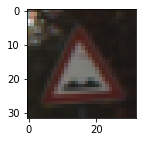

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

i = np.random.randint(0, len(X_train))
image = X_train[i].squeeze()

plt.figure(figsize = (2,2))
plt.imshow(image)
print("Label for given image: ", y_train[i])

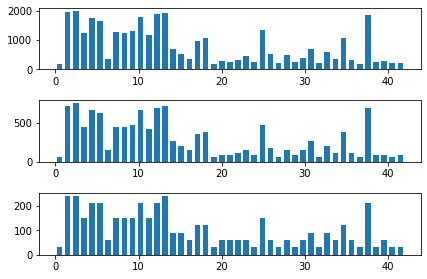

In [5]:
# Create graph showing occurance of each label
hist_train, bins = np.histogram(y_train, bins = n_classes)
hist_test, bins = np.histogram(y_test, bins = n_classes)
hist_valid, bins = np.histogram(y_valid, bins = n_classes)

fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad = 1)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
axs[0].bar(center, hist_train, align='center', width=width)                           
axs[1].bar(center, hist_test, align='center', width=width)
axs[2].bar(center, hist_valid, align='center', width=width)
plt.show()

On image above we can see histogram of each part of the data set (Train, Test and Validation subsets respectively). From given histograms we can conclude that dataset is not balanced, since there is no equal number of appearances for each label. This could prove to be one factor which reduces prediction accuracy for  traffic signs that appear less frequently.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# We want to normalize input so we have 0 mean
def normalize(input):
    normalized = np.array((input - 128.0) / 128.0)
    return normalized


In [7]:
from sklearn.utils import shuffle

# Intially shuffle training set
X_train, y_train = shuffle(X_train, y_train)

print("Mean of image before normalization: ", np.mean(X_train[0]))
print("Variance of image before normalization: ", np.var(X_train[0]))

# Normalize data set
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)
X_valid_normalized = normalize(X_valid)

print("Mean of image after normalization: ", np.mean(X_train_normalized[0]))
print("Variance of image after normalization: ", np.var(X_train_normalized[0]))


Mean of image before normalization:  90.00846354166667
Variance of image before normalization:  1834.4979752434626
Mean of image after normalization:  -0.2968088785807292
Variance of image after normalization:  0.11196887055929337


### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Tensorflow imports
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20
BATCH_SIZE = 128

/home/godra/anaconda3/envs/tensor_flow_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/godra/anaconda3/envs/tensor_flow_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/godra/anaconda3/envs/tensor_flow_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/godra/anaconda3/

In [9]:
# Create weights and biases for NN
# Parameters for initial random values for weights
mu = 0 # mean
sigma = 0.1 # deviation

weights = {
    'conv_w1' : tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 6), mean = mu, stddev = sigma)),
    'conv_w2' : tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma)),
    'conv_w3' : tf.Variable(tf.truncated_normal(shape = (3, 3, 16, 32), mean = mu, stddev = sigma)),
    'fc_w1' : tf.Variable(tf.truncated_normal(shape = (688, 120), mean = mu, stddev = sigma)),
    'fc_w2' : tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),
    'fc_w3' : tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
}
biases = {
    'conv_b1' : tf.Variable(tf.zeros(6)),
    'conv_b2' : tf.Variable(tf.zeros(16)),
    'conv_b3' : tf.Variable(tf.zeros(32)),
    'fc_b1' : tf.Variable(tf.zeros(120)),
    'fc_b2' : tf.Variable(tf.zeros(84)),
    'fc_b3' : tf.Variable(tf.zeros(43))
}

In [10]:
# Function for nn inference
def le_tsc_net(input, weights, biases, dropout):
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6. 
    conv_1 = tf.nn.bias_add(tf.nn.conv2d(x, weights['conv_w1'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv_b1'])

    # Activation.
    conv_1_activation = tf.nn.relu(conv_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    max_pooling1 = tf.nn.max_pool(conv_1_activation, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv_2 = tf.nn.bias_add(tf.nn.conv2d(max_pooling1, weights['conv_w2'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv_b2'])
    
    # Activation.
    conv_2_activation = tf.nn.relu(conv_2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    max_pooling2 = tf.nn.max_pool(conv_2_activation, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

    # Layer 3: Convolution. Input 5x5x16. Output = 3x3x32
    conv_3 = tf.nn.bias_add(tf.nn.conv2d(max_pooling2, weights['conv_w3'], strides=[1, 1, 1, 1], padding = 'VALID'), biases['conv_b3'])

    # Activation.
    conv_3_activation = tf.nn.relu(conv_3)

    # Flatten. Input = 5x5x16. Output = 400.
    flattened_conv2 = tf.contrib.layers.flatten(max_pooling2)

    # Flatten. Input = 3x3x32. Output = 288.
    flattened_conv3 = tf.contrib.layers.flatten(conv_3_activation)

    # Concatenated output. Output = 688
    concated_convs = tf.concat([flattened_conv2, flattened_conv3], 1)
    
    # Layer 3: Fully Connected. Input = 688. Output = 120.
    fc1 = tf.add(tf.matmul(concated_convs, weights['fc_w1']), biases['fc_b1'])
    
    # Activation.
    fc1_activation = tf.nn.relu(fc1)
    fc1_activation = tf.nn.dropout(fc1_activation, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1_activation, weights['fc_w2']), biases['fc_b2'])
    
    # Activation.
    fc2_activation = tf.nn.relu(fc2)
    fc2_activation = tf.nn.dropout(fc2_activation, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2_activation,  weights['fc_w3']), biases['fc_b3'])
    
    return logits



In [11]:
total_classes = n_classes

# Define inputs
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, total_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Training operations
rate = 0.001

# Output of nn
logits = le_tsc_net(x, weights, biases, keep_prob)

# Cross entropy to determin error
cross_entropy_operation = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)

# Loss - mean of cross entropy
loss_operation = tf.reduce_mean(cross_entropy_operation)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Model Evaluation
Evaluate model loss and accuracy

In [13]:
# Check for equality between nn prediciton and given labels
correct_prediciton = tf.equal(tf.arg_max(one_hot_y, 1), tf.arg_max(logits, 1))

# Calculate total accuracy as mean of vector with 0 (false predictions one_hot_y != logits) and 1 (true predictions)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediciton, tf.float32))

# Saver - utilized for saving weights of current session
saver = tf.train.Saver()

Instructions for updating:
Use `argmax` instead


In [14]:
# Utility function for printing stats
# Check total accuracy for current weights on test
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Model training
- Run the model on training data
- Before each epoch shuffle set
- After each epoch evaluate current state of the model (Accuracy) on validation set
- Save the model after training

In [17]:
# Training the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # For each epoch shuffle train dataset
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            # Feed normalized train dataset
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.50})

        # For each epoch evaluate training and validation accuracy    
        training_accuracy = evaluate(X_train_normalized, y_train)
        validation_accuracy = evaluate(X_valid_normalized, y_valid)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    sess.close()

Training...

EPOCH 1 ...
Training Accuracy = 0.671
Validation Accuracy = 0.615

EPOCH 2 ...
Training Accuracy = 0.855
Validation Accuracy = 0.796

EPOCH 3 ...
Training Accuracy = 0.916
Validation Accuracy = 0.878

EPOCH 4 ...
Training Accuracy = 0.945
Validation Accuracy = 0.883

EPOCH 5 ...
Training Accuracy = 0.949
Validation Accuracy = 0.900

EPOCH 6 ...
Training Accuracy = 0.969
Validation Accuracy = 0.927

EPOCH 7 ...
Training Accuracy = 0.975
Validation Accuracy = 0.933

EPOCH 8 ...
Training Accuracy = 0.979
Validation Accuracy = 0.932

EPOCH 9 ...
Training Accuracy = 0.982
Validation Accuracy = 0.929

EPOCH 10 ...
Training Accuracy = 0.985
Validation Accuracy = 0.939

EPOCH 11 ...
Training Accuracy = 0.989
Validation Accuracy = 0.952

EPOCH 12 ...
Training Accuracy = 0.990
Validation Accuracy = 0.956

EPOCH 13 ...
Training Accuracy = 0.991
Validation Accuracy = 0.959

EPOCH 14 ...
Training Accuracy = 0.992
Validation Accuracy = 0.951

EPOCH 15 ...
Training Accuracy = 0.993
Valid

**Check point is here, from here we have model saved!**

In [18]:
# Check the test accuracy

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.939


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Additional data mean:  -0.13495381673177084
Additional data var:  0.3110404415418291
Labels:  [25, 13, 18, 17, 1]


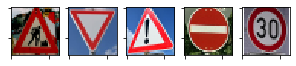

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import cv2
import glob

fig, axs = plt.subplots(1, 5, figsize = (5, 1))

# Turn off tick labels
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Load additional test images - Images are already scaled to 32x32x3
image_list = []
for filename in glob.glob('test-images/*.png'):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_list.append(image)

# Display images
i = 0
for image in image_list:
    axs[i].imshow(image)
    i = i + 1

# Create input data
X_test_additional = np.array(image_list)
Y_test_additional = [25, 13, 18, 17, 1]

# Preprocess additional test data
X_test_additional_normalized = normalize(X_test_additional)
print('Additional data mean: ', np.mean(X_test_additional_normalized))
print('Additional data var: ', np.var(X_test_additional_normalized))
print('Labels: ', Y_test_additional)

### Predict the Sign Type for Each Image and Analyze Performance

In [24]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    additional_test_saver = tf.train.import_meta_graph('./lenet.meta')
    additional_test_saver.restore(sess, "./lenet")
    additional_test_accuracy = evaluate(X_test_additional_normalized, Y_test_additional)
    print("Additional test accuracy = {:.3f}".format(additional_test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Additional test accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [27]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# Find top k values from softmax
softmax_operation = tf.nn.softmax(logits)
top_k_operation = tf.nn.top_k(softmax_operation, k = 5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    top_k_saver = tf.train.import_meta_graph('./lenet.meta')
    top_k_saver.restore(sess, "./lenet")
    # Acquire top 5 probabilities
    top_k = sess.run(top_k_operation, feed_dict={x: X_test_additional_normalized, keep_prob: 1.0})


INFO:tensorflow:Restoring parameters from ./lenet


Now after we acquired top 5 predictions for each of the test images, we should output these informations.

In [28]:
# Read all the label names from sign names
sign_names_file = open("signnames.csv", "r")

# Skip 1st line
sign_names_file.readline()
lines = sign_names_file.read().split('\n')
# Discard last line
lines = lines[0:-1]

# Prepare list for with sign names
sign_names = []
for line in lines:
    sign_names.append(line.split(',')[1])

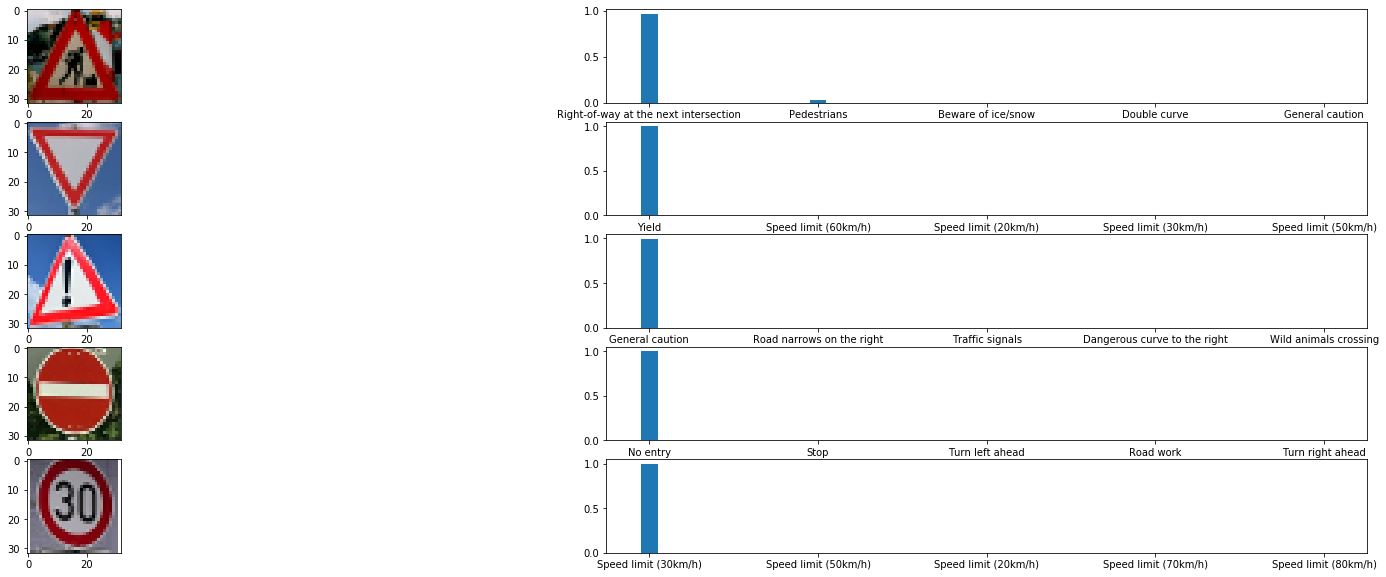

In [29]:
# Prepare plots
f, ax = plt.subplots(5, 2, figsize = (30, 10))

# Print predicitons for each value
for i in range(5):
    x = (sign_names[top_k.indices[i][0]],
        sign_names[top_k.indices[i][1]],
        sign_names[top_k.indices[i][2]],
        sign_names[top_k.indices[i][3]],
        sign_names[top_k.indices[i][4]])

    ax[i][0].imshow(image_list[i])
    ax[i][1].bar(x, top_k.values[i], 0.1)